In [43]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
sys.path.append("/Users/kushagra/Documents/personal-repo/NLP/NLP-Exploratorium")

from config import config

# Starting out with RNNs

Recreating examples from Franscois Chollet's for chapter's 10 and 11

Chapter 10 introduces about RNN's and LSTMs whereas chapter 11 is about NLP

In [2]:
df = pd.read_csv(Path(config.DATA_DIR)/'jena_climate_2009_2016.csv')

In [3]:
temperature = df['T (degC)'].values
df = df.drop(columns=['Date Time'])

In [4]:
raw_data = df.values

In [5]:
temperature.shape[0]

420451

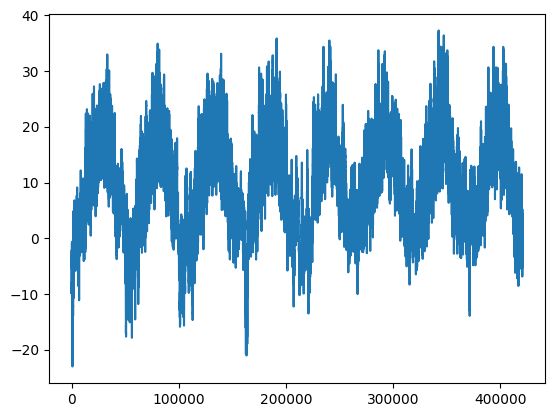

In [6]:
plt.plot(temperature)
plt.show()

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data/=std

## Understanding timeseries_dataset_from_array()

In [8]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


2023-05-28 13:40:18.115925: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

## Train, Test and Val datasets

In [45]:
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

## Baseline

In [46]:
def evaluate_naive_method(dataset):
    total_abs_error = 0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_error += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_error/samples_seen

In [47]:
evaluate_naive_method(test_dataset)

2.441735748565516

## Dense Neural Network

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation = 'relu')(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(f"{config.MODEL_WEIGHTS}/jena_dense.keras",
            save_best_only=True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 23s 27ms/step - loss: 13.2214 - mae: 2.8147 - val_loss: 11.6379 - val_mae: 2.6900
Epoch 2/10
819/819 [==============================] - 22s 26ms/step - loss: 9.3207 - mae: 2.4041 - val_loss: 12.5792 - val_mae: 2.8105
Epoch 3/10
819/819 [==============================] - 22s 26ms/step - loss: 8.4745 - mae: 2.2939 - val_loss: 11.5537 - val_mae: 2.6852
Epoch 4/10
819/819 [==============================] - 21s 26ms/step - loss: 7.9716 - mae: 2.2251 - val_loss: 11.9371 - val_mae: 2.7292
Epoch 5/10
819/819 [==============================] - 22s 27ms/step - loss: 7.6042 - mae: 2.1755 - val_loss: 13.5580 - val_mae: 2.9185
Epoch 6/10
819/819 [==============================] - 22s 26ms/step - loss: 7.3510 - mae: 2.1408 - val_loss: 12.3571 - val_mae: 2.7808
Epoch 7/10
819/819 [==============================] - 21s 26ms/step - loss: 7.1798 - mae: 2.1135 - val_loss: 11.9210 - val_mae: 2.7263
Epoch 8/10
819/819 [==============================] - 

In [49]:
model = tf.keras.models.load_model(f"{config.MODEL_WEIGHTS}/jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

408/408 [==============================] - 8s 18ms/step - loss: 10.8957 - mae: 2.6057
Test MAE: 2.605722188949585


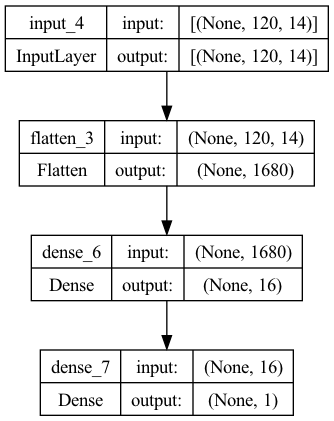

In [50]:
plot_model(model, show_shapes=True)

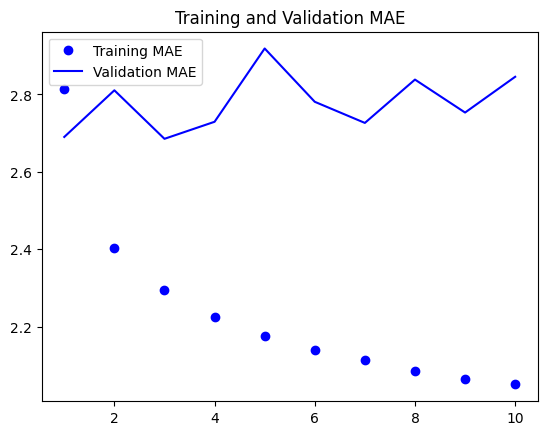

In [58]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

In [51]:
for sample, target in train_dataset:
    print(sample.shape)
    print(target.shape)
    break

(256, 120, 14)
(256,)


In [21]:
sample.numpy()[1, :, :].shape

(120, 13)

In [23]:
target[0].numpy()

15.32

In [55]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

## Conv Nets

In [60]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation = "relu")(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 12, activation = "relu")(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 6, activation = "relu")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(f"{config.MODEL_WEIGHTS}/jena_conv.keras", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, 
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 29s 32ms/step - loss: 26.8114 - mae: 3.9968 - val_loss: 21.5228 - val_mae: 3.6812
Epoch 2/10
819/819 [==============================] - 27s 32ms/step - loss: 18.0806 - mae: 3.3730 - val_loss: 22.6782 - val_mae: 3.7757
Epoch 3/10
819/819 [==============================] - 27s 32ms/step - loss: 16.1455 - mae: 3.1861 - val_loss: 21.7875 - val_mae: 3.7397
Epoch 4/10
819/819 [==============================] - 27s 32ms/step - loss: 14.7542 - mae: 3.0421 - val_loss: 21.4665 - val_mae: 3.6926
Epoch 5/10
819/819 [==============================] - 27s 33ms/step - loss: 13.9229 - mae: 2.9559 - val_loss: 24.0536 - val_mae: 3.8424
Epoch 6/10
819/819 [==============================] - 27s 32ms/step - loss: 13.3413 - mae: 2.8944 - val_loss: 22.1118 - val_mae: 3.7215
Epoch 7/10
819/819 [==============================] - 27s 33ms/step - loss: 12.9250 - mae: 2.8487 - val_loss: 22.5308 - val_mae: 3.7752
Epoch 8/10
819/819 [============================

In [61]:
model = keras.models.load_model(f"{config.MODEL_WEIGHTS}/jena_conv.keras")
model.evaluate(test_dataset)[1]

408/408 [==============================] - 8s 18ms/step - loss: 20.5777 - mae: 3.5959


3.5958685874938965

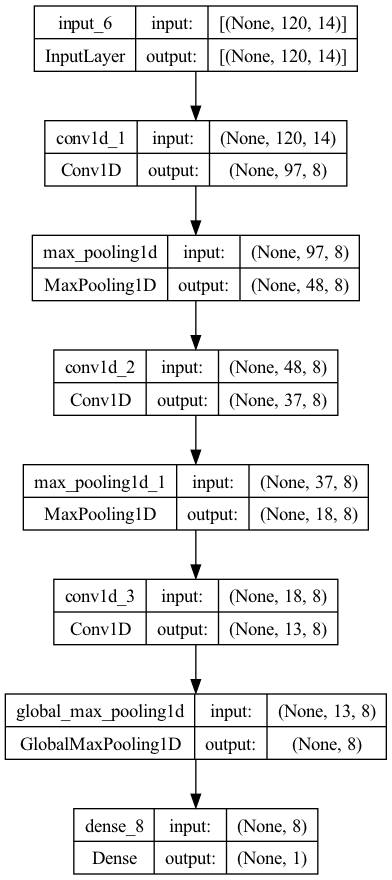

In [62]:
plot_model(model, show_shapes=True)

## RNNs

### Simple RNNs

PSEUDO-CODE-1
```python
state_t = 0
for input_t in input_sequence:
    output_t = f(input_t, state_t)
    state_t = output_t
```

PSEUDO-CODE-2
```python
state_t = 0
for input_t in input_sequence:
    output_t = activation(dot(W, input_t) + dot(U, state_t+b))
    state_t = output_t
```

PSEUDO-CODE-3
```python
timestamp = 100
input_features = 32
output_features = 64

inputs = np.random.random((timestamp, input_features))
state_t = np.zeros((output_features, ))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features, ))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)
```

PSEUDO-CODE-4 (LSTM Architecture)
```python

output_t = activation(dot(state_t, Uo) + dot(input_t, Wo) + dot(c_t, Vo) + bo)
i_t = activation(dot(state_t, Ui) + dot(input_t, Wi) + bi)
f_t = activation(dot(state_t, Uf) + dot(input_t, Wi) + bf)
k_t = activation(dot(state_t, Uk) + dot(input_t, Wk) + bk)

c_t+1 = i_t * k_t * f_t

```


**NOTES:**
- Simple RNNs take input as (batch_size, timestamps, input_features)
- Keeping timestamps as None helps you take input of arbitary length.
- All RNNs layers in keras run in two different modes controlled by the argument return_sequences
    - (batch_size, timesteps, output_features); return_sequences=True
    - (batch_size, output_features): return_sequences=False
- c_t and f_t is a way to to deliberately forget irrelevant information in the carry dataflow
- i_t and k_t provide information about the present, updating the carry track with new information



### Simple RNNs

In [73]:
# Defining timestamps as None
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)
model_1 = keras.Model(inputs, outputs)


print("Keeping timestamp as None")
print(f"Shape of input {inputs.get_shape()}")
print(f"Shape of output {outputs.get_shape()}")


# Defining timestamps as let us say 10
num_features = 14
inputs = keras.Input(shape=(10, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model_2 = keras.Model(inputs, outputs)
plot_model(model_2, show_shapes=True)

print("Keeping timestamp as 10")
print(f"Shape of input {inputs.get_shape()}")
print(f"Shape of output {outputs.get_shape()}")

Keeping timestamp as None
Shape of input (None, None, 14)
Shape of output (None, 16)
Keeping timestamp as 10
Shape of input (None, 10, 14)
Shape of output (None, 16)


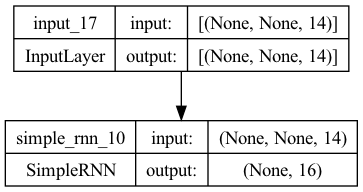

In [74]:
plot_model(model_1, show_shapes=True)

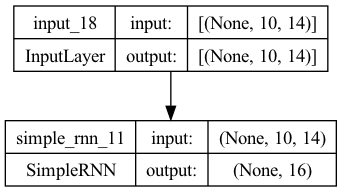

In [75]:
plot_model(model_2, show_shapes=True)

In [77]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
model = keras.Model(inputs, outputs)


print("Shape of input", inputs.shape)
print("Shape of output", outputs.shape)

Shape of input (None, 120, 14)
Shape of output (None, 120, 16)


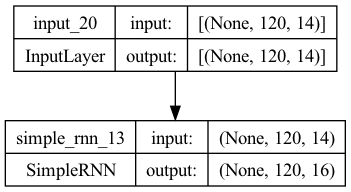

In [78]:
plot_model(model, show_shapes=True)

In [79]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
model = keras.Model(inputs, outputs)


print("Shape of input", inputs.shape)
print("Shape of output", outputs.shape)

Shape of input (None, 120, 14)
Shape of output (None, 16)


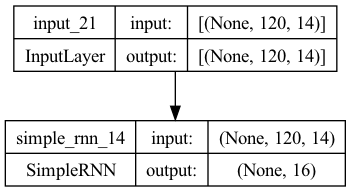

In [81]:
plot_model(model, show_shapes=True)

### Deep RNN

In [83]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

model = keras.Model(inputs, outputs)

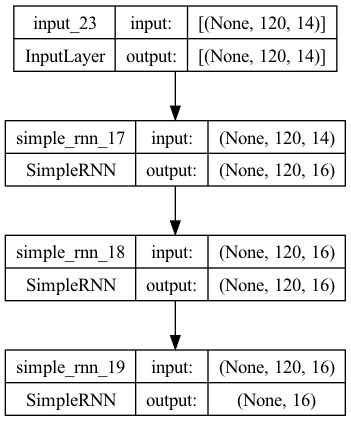

In [84]:
plot_model(model, show_shapes=True)